# Welcome!

This is a quick demo of Sawmill - a system for processing logs to help extract causal insights!

As this work is currently in process, we're looking forward to any comments and/or suggestions.

In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../..")
from src.sawmill.sawmill import Sawmill
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

## Synthetic Example

Let's start with a basic example of a synthetic log. This log contains three different log line *templates*, each of which reports the value of one of the variables `x`, `y` and `z`. Here is an example of each line:

```
2023-03-14T20:55:49.234591Z DATA The current line will include the value of z = 100.0
2023-03-14T20:55:49.233591Z DATA Short message with x = 199.05342369055703
2023-03-14T20:55:49.232591Z DATA This is a log message that reports y = 399.82103707673997
```

Each millisecond, we decide whether or not to "flip" the value of `z` between 100 and 200, with probability `1%`. If we end up flipping it, we print a log line that reports the new value (first template above).

Each millisecond, we print the value of `x` (second template above), which is generated each time by taking the most recent value of `z` and adding random noise in `[-1,1]`.

Finally, each millisecond we print the value of `y` with probability `50%`(third template above). The value of `y` is generated each time by taking the most recent value of `z`, multiplying it by `2` and adding random noise in `[-1,1]`.

Let's create a Sawmill instance and initialize it with the path to this log:


In [2]:
s = Sawmill("datasets_raw/xyzw_logs/log_2023-03-14_20:55:49.log", workdir='datasets/xyzw_logs/log_2023-03-14_20:55:49')

Initialized Sawmill with log file datasets_raw/xyzw_logs/log_2023-03-14_20:55:49.log
Work directory set to datasets/xyzw_logs/log_2023-03-14_20:55:49


### Parsing and tagging variables

We can call the `parse()` function to parse the log into a table using the [Drain](https://jiemingzhu.github.io/pub/pjhe_icws2017.pdf) algorithm. 

The Drain algorithm can first extract named variables from each log line using regular expressions. By default, Sawmill provides a single regular expression to capture timestamps in the format shown above, naming the resulting field `Timestamp`, but users can parse additional regular expressions to the `parse()` call as a dictionary, via the `regex_dict` parameter.

Then, the Drain algorithm separated log lines into "templates" and "variables", based on the similarity of each new line to the lines seen before it. You can find more information in the paper.

In [3]:
s.parse(force=True, regex_dict={'DateTime': r'\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}.\d{6}Z'})
s.parsed_log.head()

Parsing file: datasets_raw/xyzw_logs/log_2023-03-14_20:55:49.log


Reading and tokenizing log lines...:   0%|          | 0/15121 [00:00<?, ?it/s]

Determining template for each line...:   0%|          | 0/15121 [00:00<?, ?it/s]

Extracting variables from each log message...:   0%|          | 0/3 [00:00<?, ?it/s]

Determining variable types...:   0%|          | 0/4 [00:00<?, ?it/s]

Casting date variables...:   0%|          | 0/1 [00:00<?, ?it/s]

Casting date variables round 2...:   0%|          | 0/15121 [00:00<?, ?it/s]

/home/markakis/logs-venv/lib/python3.11/site-packages/tqdm/std.py:920: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return getattr(df, df_function)(wrapper, **kwargs)


Casting time variables...: 0it [00:00, ?it/s]

Casting time variables round 2...: 0it [00:00, ?it/s]

/home/markakis/logs-venv/lib/python3.11/site-packages/tqdm/std.py:920: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return getattr(df, df_function)(wrapper, **kwargs)


Casting numerical variables...:   0%|          | 0/4 [00:00<?, ?it/s]

Tagging variables...:   0%|          | 0/4 [00:00<?, ?it/s]

Detecting identifiers...:   0%|          | 0/4 [00:00<?, ?it/s]

Dumping pkl file to datasets/xyzw_logs/log_2023-03-14_20:55:49/log_2023-03-14_20:55:49.log_parsed_log_None_Non…

Dumping pkl file to datasets/xyzw_logs/log_2023-03-14_20:55:49/log_2023-03-14_20:55:49.log_parsed_templates_No…

Dumping pkl file to datasets/xyzw_logs/log_2023-03-14_20:55:49/log_2023-03-14_20:55:49.log_parsed_variables_No…

Parsing complete in 1.253333 seconds!


,TemplateId,DateTime,43e6c5b5_7,f2e46af4_11,f98340b4_12
0,43e6c5b5,1.678827e+09,100.002860,NaN,NaN
1,f2e46af4,1.678827e+09,NaN,200.189963,NaN
2,43e6c5b5,1.678827e+09,100.812299,NaN,NaN
3,f2e46af4,1.678827e+09,NaN,200.458986,NaN
4,43e6c5b5,1.678827e+09,100.260164,NaN,NaN


Let's take a look at the extracted templates. Indeed, Drain has detected the three templates in the synthetic log. Each template is given a hash-based template ID. For each template, we see that a variable has been detected (at word indices 7, 11 and 12, respectively) and replaced with `<*>` in the template text. 

For each template, we also got a regular expression match at index 0, corresponding to the regular expression that matches timestamps. The timestamps were correspondingly replaced by `<*0>`, since that was the 0th (and only) regular expression we provided.

In [4]:
s.parsed_templates

,TemplateText,TemplateId,VariableIndices,RegexIndices,TemplateExample,Occurrences
0,<*0> DATA Short message with x = <*>,43e6c5b5,[7],[0],<*0> DATA Short message with x = 100.00285967800117,10000
1,<*0> DATA This is a log message that reports y = <*>,f2e46af4,[11],[0],<*0> DATA This is a log message that reports y = 200.1899632341074,5006
2,<*0> DATA The current line will include the value of z = <*>,f98340b4,[12],[0],<*0> DATA The current line will include the value of z = 200.0,115


We can also look at the extracted variables. For variables that were extracted via a regular expression, like the timestamp, the user has already provided a name (in this case, `Timestamp`). For the rest, a variable name is generated from the corresponding template ID and the index that the variable appear in, within the template. For each variable, we also report the preceding 3 tokens and some example values. 

Since the automatically-generated names are not meaningful, we also allow for each variable to carry a tag. Initial values of these tags are guessed from the preceding tokens of each variable:

In [5]:
s.parsed_variables

,Name,Tag,TagOrigin,Type,IsUninteresting,Occurrences,Preceding 3 tokens,Examples,From regex
0,DateTime,DateTime,4,num,False,15121,[],"[2023-03-14T20:55:49.165591Z, 2023-03-14T20:55:49.166591Z, 2023-03-14T20:55:49.167591Z, 2023-03-14T20:55:49.168591Z, 2023-03-14T20:55:49.169591Z]",True
1,43e6c5b5_7,x,0,num,False,10000,"[with, x, =]","[100.00285967800117, 100.81229891323964, 100.26016363495995, 199.4482406365968, 200.98748260974]",False
2,f2e46af4_11,y,0,num,False,5006,"[reports, y, =]","[200.1899632341074, 200.45898567905772, 399.6905765982258, 400.22712382793407, 400.08343040509993]",False
3,f98340b4_12,z,0,num,False,115,"[of, z, =]","[200.0, 100.0]",False


However, the user is free to change or provide the tag of a variable as they like:

In [6]:
s.tag_parsed_variable("43e6c5b5_7", "X")
s.parsed_variables

Variable 43e6c5b5_7 tagged as X


,Name,Tag,TagOrigin,Type,IsUninteresting,Occurrences,Preceding 3 tokens,Examples,From regex
0,DateTime,DateTime,4,num,False,15121,[],"[2023-03-14T20:55:49.165591Z, 2023-03-14T20:55:49.166591Z, 2023-03-14T20:55:49.167591Z, 2023-03-14T20:55:49.168591Z, 2023-03-14T20:55:49.169591Z]",True
1,43e6c5b5_7,X,0,num,False,10000,"[with, x, =]","[100.00285967800117, 100.81229891323964, 100.26016363495995, 199.4482406365968, 200.98748260974]",False
2,f2e46af4_11,y,0,num,False,5006,"[reports, y, =]","[200.1899632341074, 200.45898567905772, 399.6905765982258, 400.22712382793407, 400.08343040509993]",False
3,f98340b4_12,z,0,num,False,115,"[of, z, =]","[200.0, 100.0]",False


### Defining the causal unit and aggregating

To continue our analysis, we would like to structure and complete the parsed information to form "causal units", which will be the units on which our causal analysis will be performed. If we think of causality in other contexts, the causal units could be patients in a medical context, or individuals in an economic/social study.

Causal units are defined by one of the available attributes. In a medical context, this could be "patient name". In a systems context, we could pick one of the variables parsed from the log. This decision should normally come from the user's domain knowledge.

If the user is unsure of which causal unit to pick, the system can provide suggestions, based on minimizing the impact of any missing data in the log. This technique may or may not lead to semantically meaningful causal unit suggestions.

In [7]:
s.suggest_causal_unit_defs()

,Variable,Type,Num Units,IUS
0,DateTime,num,4,1.000000
1,DateTime,num,8,1.000000
2,DateTime,num,40,0.993734
3,43e6c5b5_7,num,4,0.330666
4,43e6c5b5_7,num,8,0.330666
5,43e6c5b5_7,num,40,0.330666
6,f2e46af4_11,num,4,0.165531
7,f2e46af4_11,num,8,0.165531
8,f2e46af4_11,num,40,0.165531


Based on the user's own domain knowledge or the system's suggestions, the user can then call `set_causal_unit()`. For example, the call below indicates that each causal unit should be a `1 ms`-long time interval (not that this choice may not be appropriate in every setting):

In [8]:
s.set_causal_unit("DateTime", num_units=10000)

Causal unit set to DateTime (tag: DateTime)  with 10000 causal units.


Given the causal unit, we can then ask Sawmill to perpare the log for analysis by using `prepare()`. Preparing the log involves two distinct tasks:

1. Aggregation: Based on our choice of causal unit, there might be variables that take a multitude of values on different log lines associated with the same causal unit. For example, had we chosen a 10ms window as our causal unit, there would have been 10 lines reporting values of `x`. From this multitude of values, a fixed set of values must be derived (e.g. we could always keep the mean, or the last value seen). By default, Sawmill will generate the `min`, `max` and `mean` for numerical variables; the most recent value for string variables; and the least recent value for date-typed variables.

2. Imputation: On the other end of the spectrum, there might be variables that are never observed within some causal unit. For example, `z` is only reported every approximately `100 ms`, so it should be missing most of the time, if our causal unit is a `1 ms` window. Whether and how to impute such missing values is application-dependent, since we must avoid information leakage from one causal unit to another or risk violating SUTVA. In this case, we know that `z` should be interpreted as a "sticky" value, but `x` and `y` should not be imputed.

After aggregating and imputing, we drop any causal units that still have missing values.

In [9]:
imputation_functions = {'z': 'ffill_imp'}
aggregation_functions = {'DateTime': ['max']}
s.prepare(custom_agg=aggregation_functions, custom_imp=imputation_functions, force=True)
s.prepared_log.head(10)

Determining the causal unit assignment...
Dropped 0 uninteresting columns, out of an original total of 4.
Calculating aggregates for each causal unit...


Imputing missing values...:   0%|          | 0/9 [00:00<?, ?it/s]

Dropping aggregates that do not add information...


One-hot encoding categorical variables...: 0it [00:00, ?it/s]

Dumping pkl file to datasets/xyzw_logs/log_2023-03-14_20:55:49/log_2023-03-14_20:55:49.log_prepared_log_DateTi…

Dumping pkl file to datasets/xyzw_logs/log_2023-03-14_20:55:49/log_2023-03-14_20:55:49.log_prepared_variables_…

Successfully prepared the log with causal unit DateTime (tag: DateTime) with 10000 causal units.
Pruning edges...


Finding pruned variables...:   0%|          | 0/3 [00:00<?, ?it/s]

Preparation complete in 6.504448 seconds! 3 of the 9 possible edges were auto-rejected.


,43e6c5b5_7+mean,f2e46af4_11+mean,f98340b4_12+mean
DateTime+max,,,
1678827349.170591,199.659262,399.690577,200.0
1678827349.173591,199.755998,400.227124,200.0
1678827349.175591,200.098576,400.083430,200.0
1678827349.178591,200.158634,399.188180,200.0
1678827349.179591,200.934658,400.514334,200.0
1678827349.181591,199.626578,399.894171,200.0
1678827349.182591,200.937334,400.577257,200.0
1678827349.183591,199.831092,399.077464,200.0
1678827349.188591,199.372097,399.650472,200.0


In [10]:
s.prepared_variables

,Name,Base,Pre-agg Value,Agg,Post-agg Value,Tag,Base Variable Occurences,Type,Examples,From regex,TemplateText
0,43e6c5b5_7+mean,43e6c5b5_7,,mean,,X mean,10000,num,"[100.00285967800117, 100.81229891323964, 100.26016363495995, 199.4482406365968, 200.98748260974]",False,<*0> DATA Short message with x = <*>
1,f2e46af4_11+mean,f2e46af4_11,,mean,,y mean,5006,num,"[200.1899632341074, 200.45898567905772, 399.6905765982258, 400.22712382793407, 400.08343040509993]",False,<*0> DATA This is a log message that reports y = <*>
2,f98340b4_12+mean,f98340b4_12,,mean,,z mean,115,num,"[200.0, 100.0]",False,<*0> DATA The current line will include the value of z = <*>


### Obtaining a causal graph

Along with data organized along the lines of causal units, performing causal analysis also requires a causal graph. Our system provides a few different methods for obtaining such a graph, which we will now describe. 

#### Obtaining a graph through exploration

In this variable, we iteratively pick the variable that interests us and ask the system for candidate causes for it. Remember from our data generation process, that `y` appears to be roughly equal to `2x`, but that both `x` and `y` are in fact driven by the value of `z`:

In [11]:
s.explore_candidate_causes("y mean") 

Candidate cause exploration complete in 0.908403 seconds!


(          Candidate Candidate Tag            Target     Slope  P-value Candidate->Target Edge Status Target->Candidate Edge Status
 0   43e6c5b5_7+mean        X mean  f2e46af4_11+mean  1.999968      0.0                     Undecided                     Undecided
 1  f98340b4_12+mean        z mean  f2e46af4_11+mean  2.000228      0.0                     Undecided                     Undecided,
 '0.908403')

As expected, the system cannot meaningfully distinguish between the impact of `X` and `z` on `y`, since `X` is essentially a slightly noisy version of `z`. Both are reported with similar relationship strengths, so let's accept both edges into the causal graph.


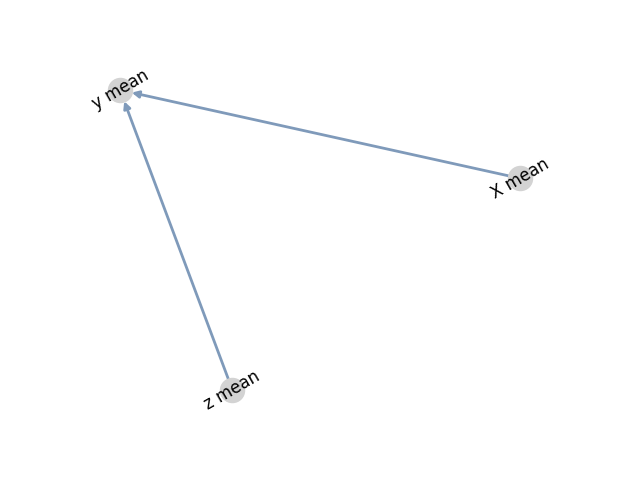

(0.6666666666666666, '43e6c5b5_7+mean', '')

In [12]:
s.accept('X mean', 'y mean', interactive=False)
s.accept('z mean', 'y mean')

However, let's now assume that we are (thankfully) not yet fully convinced, and would like to look for any possible confounding. Let's ask the system for candidates causes of `X`, which is also the candidate that the system suggested we explore next after our most recent call to `accept()`:

In [13]:
s.explore_candidate_causes("X mean")

Candidate cause exploration complete in 0.897520 seconds!


(          Candidate Candidate Tag           Target     Slope  P-value Candidate->Target Edge Status Target->Candidate Edge Status
 0  f2e46af4_11+mean        y mean  43e6c5b5_7+mean  0.498826      0.0                      Rejected                      Accepted
 1  f98340b4_12+mean        z mean  43e6c5b5_7+mean  0.997800      0.0                     Undecided                     Undecided,
 '0.897520')

`z` is successfully detected once more, and we can use domain knowledge to judge that `z` influencing `X` is the correct direction. Indeed, let's see what happens if we add it to the graph:


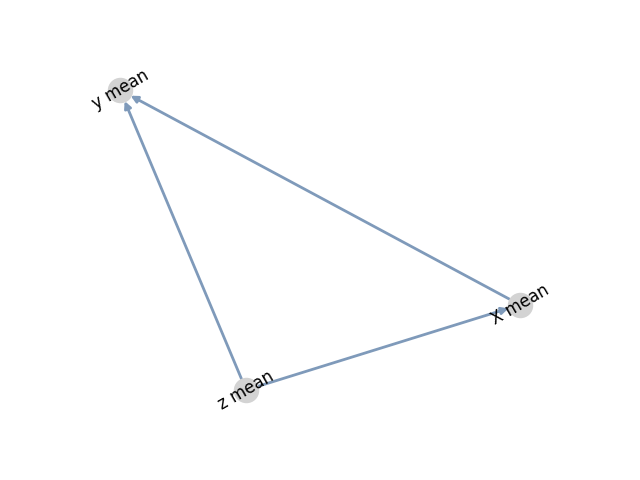

(1.0, None, '')

In [14]:
s.accept('z mean', 'X mean')

Our graph creation is now complete. If the system had suggested further candidate causes that were not already rejected, we could make sure they are marked as such.


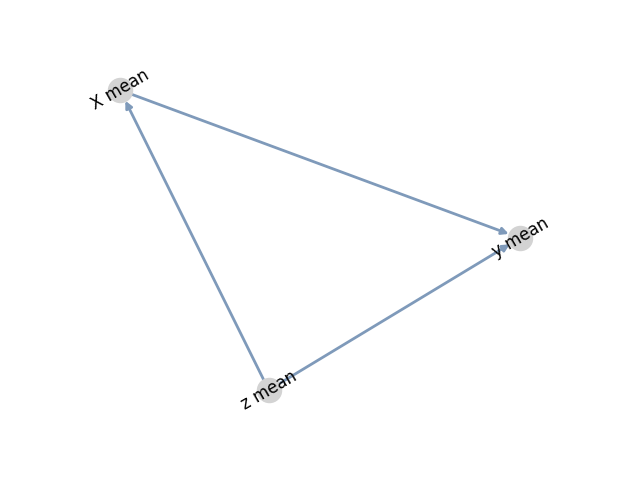

(1.0, None, '')

In [15]:
s.reject_undecided_incoming('z mean')

#### Obtaining a graph through automatic causal discovery

For instances of the problem with few prepared variables, we could also attempt to use an off-the-shelf causal discovery algorithm to find a causal graph.

In [16]:
s.clear_graph()

In [17]:
s.discover_graph(method='hill_climb')

  0%|          | 0/10000 [00:00<?, ?it/s]

Marking edge as accepted:  ('43e6c5b5_7+mean', 'f2e46af4_11+mean')
Marking edge as accepted:  ('f98340b4_12+mean', 'f2e46af4_11+mean')
Marking edge as accepted:  ('f98340b4_12+mean', '43e6c5b5_7+mean')



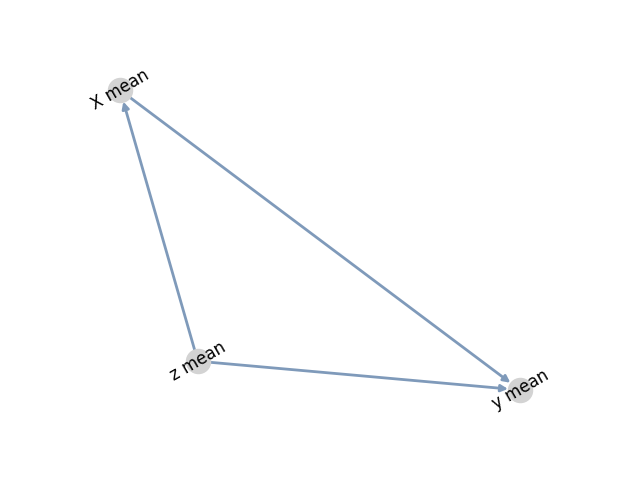

In [18]:
s.display_graph()

As we see, this is almost correct, but the edge between `X` and `y` is flipped. We can correct this by just accepting the right edge.


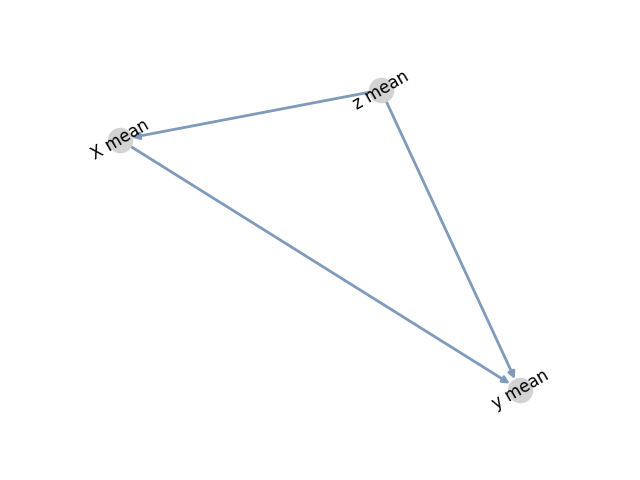

(1.0, None, '')

In [19]:
s.accept('X mean', 'y mean')

### Calculating and refining the ATE

Now that we are in posession of both a transformed view of the log data and a causal graph, it is time to calculate the ATE we are interested in. We can ask the system to either adjust for the right variables based on the causal graph we have created, or not.

In [20]:
s.get_adjusted_ate('X mean', 'y mean')

In [21]:
s.get_unadjusted_ate('X mean', 'y mean')

As expected, adjusting for the right variables based on the causal graph is crucial in this case, since `Z` is by design a confounder of the causal effect of interest. Beacuse of this, we may be interested in exactly which edges of the causal graph make the biggest ATE impact, so that we can think twice about the assumptions that they encode. We can ask the system which changes to the graph would swing the ATE by the most.

The system can either answer by considering simple one-edge changes to the current graph, which suggests that graph changes that would have big ATE impact all remove `z` as a confounder...

In [22]:
s.challenge_ate('X mean', 'y mean', method='step')

Enumerated 9 graphs with 3 nodes.


0it [00:00, ?it/s]

,Source,Source Tag,Target,Target Tag,Change,ATE,Baseline ATE,ATE Ratio
0,f98340b4_12+mean,z mean,f2e46af4_11+mean,y mean,Remove,1.999968,-0.000376,5321.786986
2,f98340b4_12+mean,z mean,43e6c5b5_7+mean,X mean,Reverse,1.999968,-0.000376,5321.786986
1,f98340b4_12+mean,z mean,43e6c5b5_7+mean,X mean,Remove,0.265125,-0.000376,705.479462


...or we can ask the system to take a step back and consider a broader set of possible graphs and the ATEs they lead to. This approach can accept a large number of configuration parameters through `ClusteringParams` and is generally more time-consuming. In this case, it also comes down to whether or not we assume `z` is a confounder.

Loading existing pkl file datasets/xyzw_logs/log_2023-03-14_20:55:49/pickles/effects/43e6c5b5_7+mean_f2e46af4_…

Found 2 clusters
For ate = 1.999968130608398, the following edges are key assumptions made of the causal graph.


,Edge,% Expectancy,Status
1,"(z mean, y mean)",-0.555556,DOES NOT EXIST
0,"(z mean, X mean)",-0.333333,DOES NOT EXIST


For ate = 0.13237437690649756, the following edges are key assumptions made of the causal graph.


,Edge,% Expectancy,Status
1,"(z mean, y mean)",1.666667,EXISTS
0,"(z mean, X mean)",1.000000,EXISTS


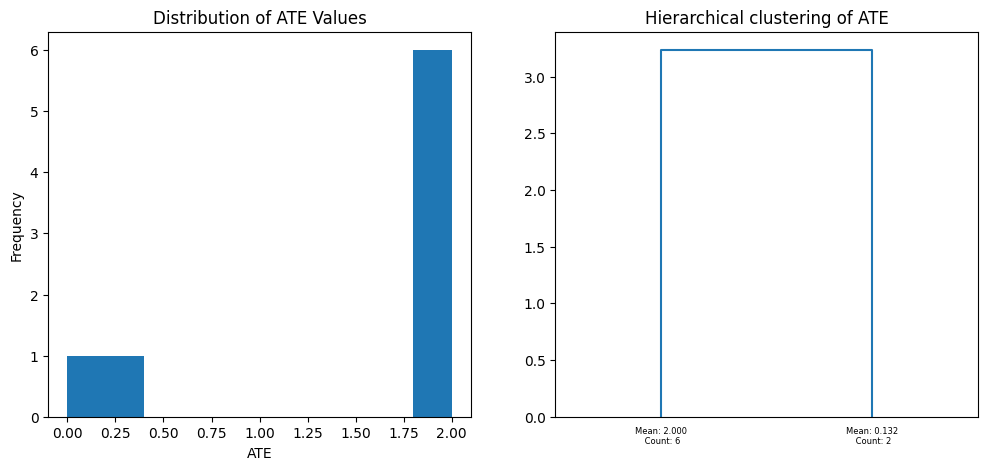

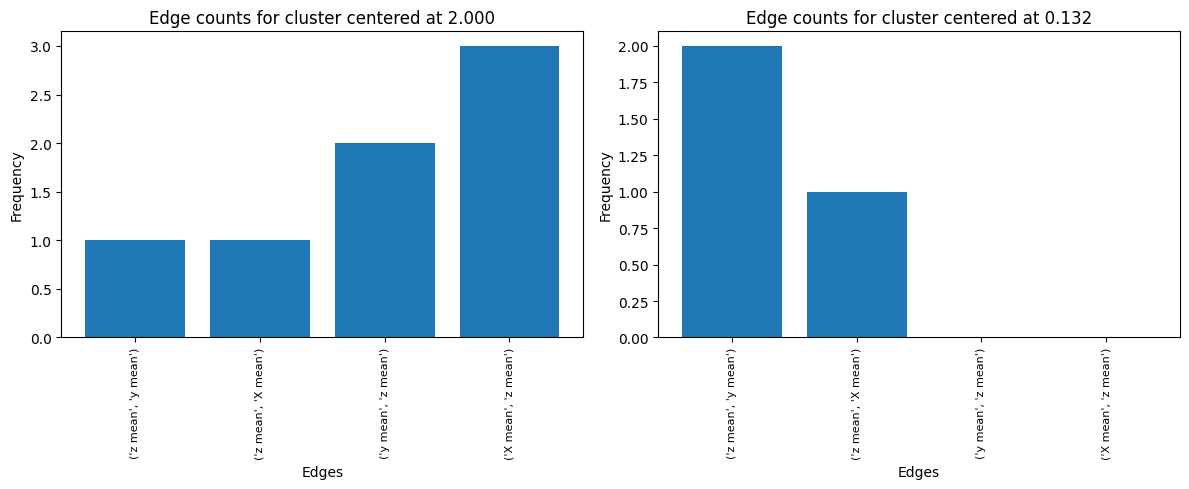

In [23]:
s.challenge_ate('X mean', 'y mean', method='clustering', ignore_current_graph=True)

# PostgreSQL/TPC-DS Example

Now that we saw the basics of the framework, let's try to apply it to logs from a real system. 

We set up a PostgreSQL instance and load it with the data from TPC-DS with scale factor 1. We then run a workload in which we issue the queries in the TPC-DS workload once each (except for 4 particularly long-running queries, to expedite development 😅). 

We use PostgreSQL's logging to capture the execution of this workload:

In [24]:
with open("datasets_raw/tpc-ds/work_mem_2_256kB_2_128kB_parallel_1_2.log", 'r') as f:
    log = f.read().split('\n')
log[15:25]

['2023-11-01 17:54:53.027 EDT [ 6542c92d.1f943 3/5186 ] postgres@tpcds1 LOG:  statement: BEGIN',
 '2023-11-01 17:54:53.027 EDT [ 6542c92d.1f943 3/5186 ] postgres@tpcds1 LOG:  duration: 0.033 ms',
 '2023-11-01 17:54:53.028 EDT [ 6542c92d.1f943 3/5186 ] postgres@tpcds1 LOG:  statement: -- Filename: query080.sql',
 '\t',
 '\twith ssr as',
 '\t (select  s_store_id as store_id,',
 '\t          sum(ss_ext_sales_price) as sales,',
 '\t          sum(coalesce(sr_return_amt, 0)) as returns,',
 '\t          sum(ss_net_profit - coalesce(sr_net_loss, 0)) as profit',
 '\t  from store_sales left outer join store_returns on']

We configure logging to print out the latency of every query, and the prefix of each line is set to `%m [ %c %v ] %q%u@%d`, where:
- %m = timestamp with milliseconds
- %c = session ID
- %v = virtual transaction ID
- %q = stop here in non-session processes
- %u = user name
- %d = database name

We run this workload 8 times total, each using a new connection -  2 runs each for each of 4 different parameter configurations. 

For each parameter configuration, we decide on a total memory budget (128 kB or 256 kB). We then set the number of `max_parallel_workers` to 1 or 2, and the amount of `work_mem` to the budget divided by the number of max parallel workers. For example:

In [25]:
log[3:15]

['2023-11-01 17:54:53.018 EDT [ 6542c92d.1f943 3/5184 ] postgres@tpcds1 LOG:  statement: BEGIN',
 '2023-11-01 17:54:53.019 EDT [ 6542c92d.1f943 3/5184 ] postgres@tpcds1 LOG:  duration: 0.076 ms',
 '2023-11-01 17:54:53.019 EDT [ 6542c92d.1f943 3/5184 ] postgres@tpcds1 LOG:  statement: SET max_parallel_workers = 1;',
 '2023-11-01 17:54:53.019 EDT [ 6542c92d.1f943 3/5184 ] postgres@tpcds1 LOG:  duration: 0.062 ms',
 '2023-11-01 17:54:53.019 EDT [ 6542c92d.1f943 3/5184 ] postgres@tpcds1 LOG:  statement: COMMIT',
 '2023-11-01 17:54:53.019 EDT [ 6542c92d.1f943 3/0 ] postgres@tpcds1 LOG:  duration: 0.030 ms',
 '2023-11-01 17:54:53.019 EDT [ 6542c92d.1f943 3/5185 ] postgres@tpcds1 LOG:  statement: BEGIN',
 '2023-11-01 17:54:53.019 EDT [ 6542c92d.1f943 3/5185 ] postgres@tpcds1 LOG:  duration: 0.023 ms',
 "2023-11-01 17:54:53.019 EDT [ 6542c92d.1f943 3/5185 ] postgres@tpcds1 LOG:  statement: SET work_mem = '128.0';",
 '2023-11-01 17:54:53.019 EDT [ 6542c92d.1f943 3/5185 ] postgres@tpcds1 LOG:  d

Can we use Sawmill to find the causal effect of these modifications on query runtime?

### Parsing and preparation

Since we run each iteration of the workload in a separate connection, we can extract the connection ID from each log line and use it to define our causal units. We also specify that each log message begins with a timestamp, so that Samwill can collapse multi-line log messages into a single message:

In [26]:
s2 = Sawmill("datasets_raw/tpc-ds/work_mem_2_256kB_2_128kB_parallel_1_2.log", workdir="datasets/tpc-ds")
s2.parse(regex_dict={"DateTime": r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d{3}(?= EDT \[ )', 
        "sessionID" : r'(?<=EDT \[ )\S+\.\S+',
        "tID": r'3/\d+(?= ] )'
        },message_prefix=r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}.\d{3}', force=True)
s2.set_causal_unit("sessionID")
custom_agg = {"sessionID": ["first"]}
s2.prepare(force = True, custom_agg=custom_agg)

Initialized Sawmill with log file datasets_raw/tpc-ds/work_mem_2_256kB_2_128kB_parallel_1_2.log
Work directory set to datasets/tpc-ds
Parsing file: datasets_raw/tpc-ds/work_mem_2_256kB_2_128kB_parallel_1_2.log


Reading and tokenizing log lines...:   0%|          | 0/42108 [00:00<?, ?it/s]

Determining template for each line...:   0%|          | 0/4687 [00:00<?, ?it/s]

Extracting variables from each log message...:   0%|          | 0/100 [00:00<?, ?it/s]

Determining variable types...:   0%|          | 0/66 [00:00<?, ?it/s]

Casting date variables...:   0%|          | 0/1 [00:00<?, ?it/s]

Casting date variables round 2...:   0%|          | 0/4687 [00:00<?, ?it/s]

/home/markakis/logs-venv/lib/python3.11/site-packages/tqdm/std.py:920: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return getattr(df, df_function)(wrapper, **kwargs)


Casting time variables...:   0%|          | 0/1 [00:00<?, ?it/s]

Casting time variables round 2...:   0%|          | 0/4687 [00:00<?, ?it/s]

/home/markakis/logs-venv/lib/python3.11/site-packages/tqdm/std.py:920: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return getattr(df, df_function)(wrapper, **kwargs)


Casting numerical variables...:   0%|          | 0/7 [00:00<?, ?it/s]

Tagging variables...:   0%|          | 0/66 [00:00<?, ?it/s]

Detecting identifiers...:   0%|          | 0/66 [00:00<?, ?it/s]

Dumping pkl file to datasets/tpc-ds/work_mem_2_256kB_2_128kB_parallel_1_2.log_parsed_log_None_None.pkl...:   0…

Dumping pkl file to datasets/tpc-ds/work_mem_2_256kB_2_128kB_parallel_1_2.log_parsed_templates_None_None.pkl..…

Dumping pkl file to datasets/tpc-ds/work_mem_2_256kB_2_128kB_parallel_1_2.log_parsed_variables_None_None.pkl..…

Parsing complete in 1.022926 seconds!
Causal unit set to sessionID (tag: sessionID) 
Determining the causal unit assignment...
Dropped 1 uninteresting columns, out of an original total of 66.
Calculating aggregates for each causal unit...


Imputing missing values...:   0%|          | 0/192 [00:00<?, ?it/s]

Dropping aggregates that do not add information...


One-hot encoding categorical variables...:   0%|          | 0/57 [00:00<?, ?it/s]

Dumping pkl file to datasets/tpc-ds/work_mem_2_256kB_2_128kB_parallel_1_2.log_prepared_log_sessionID_None.pkl.…

Dumping pkl file to datasets/tpc-ds/work_mem_2_256kB_2_128kB_parallel_1_2.log_prepared_variables_sessionID_Non…

Successfully prepared the log with causal unit sessionID (tag: sessionID)
Pruning edges...


Finding pruned variables...:   0%|          | 0/64 [00:00<?, ?it/s]

/home/markakis/logs-venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/markakis/logs-venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/markakis/logs-venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

Preparation complete in 1.676521 seconds! 4070 of the 4096 possible edges were auto-rejected.


'1.676521'

In [27]:
s2.parsed_variables.head(15)

,Name,Tag,TagOrigin,Type,IsUninteresting,Occurrences,Preceding 3 tokens,Examples,From regex,Aggregates
0,DateTime,DateTime,4,num,False,4687,[],"[2023-11-01 17:54:53.006, 2023-11-01 17:54:53.017, 2023-11-01 17:54:53.018, 2023-11-01 17:54:53.019, 2023-11-01 17:54:53.027]",True,"[mean, max, min]"
1,sessionID,sessionID,4,str,False,4687,[],"[6542c92d.1f943, 6542d880.1fc1b, 6542e76c.1fe63, 6543018c.20227, 65431bc7.20615]",True,[first]
2,tID,tID,4,str,True,4687,[],"[, 3/5183, 3/5184, 3/0, 3/5185]",True,[]
3,7f9dd6da_22,port,0,num,False,8,"[127.0.0.1, port, =]","[42396, 51214, 54898, 47566, 60122]",False,"[mean, max, min]"
4,9213789e_11,statement,0,str,False,1552,"[:, statement, :]","[BEGIN, COMMIT]",False,"[last, mode, first]"
5,2dfe3d16_11,duration,0,num,False,2327,"[:, duration, :]","[0.076, 0.062, 0.030, 0.023, 0.044]",False,"[mean, max, min]"
6,d046ac78_14,max_parallel_workers,0,num,False,8,"[SET, max_parallel_workers, =]","[1, 2]",False,"[mean, max, min]"
7,0f62d144_15,work_mem,0,num,False,8,"[work_mem, =, ']","[128.0, 64.0, 256.0]",False,"[mean, max, min]"
8,7c2f7377_14,Filename,0,str,False,16,"[--, Filename, :]","[query012.sql, query020.sql]",False,"[last, mode, first]"
9,7c2f7377_28,7c2f7377_28,3,str,False,16,"[,, sum, (]","[ws_ext_sales_price, cs_ext_sales_price]",False,"[last, mode, first]"


Now, the prepared log consists of one causal unit per run of the workload:

In [28]:
s2.prepared_log 

,DateTime+mean,7f9dd6da_22+mean,2dfe3d16_11+mean,d046ac78_14+mean,0f62d144_15+mean,2c402162_13+mean,2c402162_25+mean,9213789e_11+last=COMMIT,7c2f7377_14+last=query020.sql,7c2f7377_28+last=cs_ext_sales_price,7c2f7377_35+last=cs_ext_sales_price,7c2f7377_41+last=cs_ext_sales_price,7c2f7377_53+last=catalog_sales,7c2f7377_59+last=cs_item_sk,7c2f7377_79+last=cs_sold_date_sk,3e3b083e_14+last=query053.sql,3e3b083e_20+last=i_manufact_id,3e3b083e_39+last=i_manufact_id,3e3b083e_41+last=avg_quarterly_sales,3e3b083e_219+last=i_manufact_id,3e3b083e_221+last=d_qoy,3e3b083e_227+last=avg_quarterly_sales,3e3b083e_235+last=avg_quarterly_sales,3e3b083e_238+last=avg_quarterly_sales,3e3b083e_246+last=avg_quarterly_sales,3e3b083e_248+last=sum_sales,3e3b083e_250+last=i_manufact_id,a092a92c_14+last=query026.sql,a092a92c_20+last=cs_quantity,a092a92c_26+last=cs_list_price,a092a92c_32+last=cs_coupon_amt,a092a92c_38+last=cs_sales_price,a092a92c_42+last=catalog_sales,a092a92c_52+last=cs_sold_date_sk,a092a92c_56+last=cs_item_sk,a092a92c_60+last=cs_bill_cdemo_sk,a092a92c_64+last=cs_promo_sk,c1dbe68b_14+last=query099.sql,c1dbe68b_27+last=cc_name,c1dbe68b_34+last=cs_ship_date_sk,c1dbe68b_36+last=cs_sold_date_sk,c1dbe68b_58+last=cs_ship_date_sk,c1dbe68b_60+last=cs_sold_date_sk,c1dbe68b_66+last=cs_ship_date_sk,c1dbe68b_68+last=cs_sold_date_sk,c1dbe68b_90+last=cs_ship_date_sk,c1dbe68b_92+last=cs_sold_date_sk,c1dbe68b_98+last=cs_ship_date_sk,c1dbe68b_100+last=cs_sold_date_sk,c1dbe68b_122+last=cs_ship_date_sk,c1dbe68b_124+last=cs_sold_date_sk,c1dbe68b_130+last=cs_ship_date_sk,c1dbe68b_132+last=cs_sold_date_sk,c1dbe68b_154+last=cs_ship_date_sk,c1dbe68b_156+last=cs_sold_date_sk,c1dbe68b_172+last=catalog_sales,c1dbe68b_178+last=call_center,c1dbe68b_190+last=cs_ship_date_sk,c1dbe68b_194+last=cs_warehouse_sk,c1dbe68b_198+last=cs_ship_mode_sk,c1dbe68b_202+last=cs_call_center_sk,c1dbe68b_204+last=cc_call_center_sk,c1dbe68b_218+last=cc_name,c1dbe68b_232+last=cc_name
sessionID+first,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6542c92d.1f943,1.698863e+09,42396.0,13483.595990,1.0,128.0,3923.846,42396.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6542d880.1fc1b,1.698867e+09,51214.0,13126.180309,1.0,128.0,3819.821,51214.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6542e76c.1fe63,1.698872e+09,54898.0,22983.408399,2.0,64.0,6688.275,54898.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6543018c.20227,1.698879e+09,47566.0,23075.070997,2.0,64.0,6714.950,47566.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
65431bc7.20615,1.698883e+09,60122.0,2707.956093,1.0,256.0,808.713,60122.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
65431ef0.2073a,1.698884e+09,47102.0,2781.880526,1.0,256.0,809.632,47102.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6543221a.2085f,1.698886e+09,43972.0,13000.099663,2.0,128.0,3783.136,43972.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
654330e1.20b8f,1.698890e+09,37380.0,13005.023144,2.0,128.0,3784.566,37380.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


We ask for candidate causes of query duration:

In [29]:
s2.explore_candidate_causes("duration mean")

Candidate cause exploration complete in 0.860969 seconds!


(          Candidate              Candidate Tag            Target        Slope       P-value Candidate->Target Edge Status Target->Candidate Edge Status
 0  2c402162_13+mean                  time mean  2dfe3d16_11+mean     3.442502  1.331652e-16                     Undecided                     Undecided
 1  0f62d144_15+mean              work_mem mean  2dfe3d16_11+mean  -100.525674  2.900467e-05                     Undecided                     Undecided
 2  d046ac78_14+mean  max_parallel_workers mean  2dfe3d16_11+mean  9990.997321  5.504147e-02                     Undecided                     Undecided
 3     DateTime+mean              DateTime mean  2dfe3d16_11+mean    -0.259903  4.372292e-01                     Undecided                     Undecided
 4  7f9dd6da_22+mean                  port mean  2dfe3d16_11+mean    -0.145989  7.450969e-01                     Undecided                      Rejected
 5  2c402162_25+mean           2c402162_25 mean  2dfe3d16_11+mean    -0.145989  7.

Let's learn more about some of the top candidate causes:

In [30]:
s2.inspect('work_mem mean')

Information about prepared variable 0f62d144_15+mean:

--> Variable Information about 0f62d144_15:


,Name,Tag,TagOrigin,Type,IsUninteresting,Occurrences,Preceding 3 tokens,Examples,From regex,Aggregates
7,0f62d144_15,work_mem,0,num,False,8,"[work_mem, =, ']","[128.0, 64.0, 256.0]",False,"[mean, max, min]"


--> Template Information about 0f62d144:


,TemplateText,TemplateId,VariableIndices,RegexIndices,TemplateExample,Occurrences
6,<*0> EDT [ <*1> <*2> ] postgres@tpcds1 LOG : statement : SET work_mem = ' <*> ' ;,0f62d144,[15],"[0, 3, 4]",<*0> EDT [ <*1> <*2> ] postgres@tpcds1 LOG : statement : SET work_mem = ' 128.0 ' ;,8


--> Causal Unit Partial Information:


,0f62d144_15+mean (candidate)
sessionID+first,
6542c92d.1f943,128.0
6542d880.1fc1b,128.0
6542e76c.1fe63,64.0
6543018c.20227,64.0
65431bc7.20615,256.0
65431ef0.2073a,256.0
6543221a.2085f,128.0
654330e1.20b8f,128.0


In [31]:
s2.inspect('max_parallel_workers mean')

Information about prepared variable d046ac78_14+mean:

--> Variable Information about d046ac78_14:


,Name,Tag,TagOrigin,Type,IsUninteresting,Occurrences,Preceding 3 tokens,Examples,From regex,Aggregates
6,d046ac78_14,max_parallel_workers,0,num,False,8,"[SET, max_parallel_workers, =]","[1, 2]",False,"[mean, max, min]"


--> Template Information about d046ac78:


,TemplateText,TemplateId,VariableIndices,RegexIndices,TemplateExample,Occurrences
5,<*0> EDT [ <*1> <*2> ] postgres@tpcds1 LOG : statement : SET max_parallel_workers = <*> ;,d046ac78,[14],"[0, 3, 4]",<*0> EDT [ <*1> <*2> ] postgres@tpcds1 LOG : statement : SET max_parallel_workers = 1 ;,8


--> Causal Unit Partial Information:


,d046ac78_14+mean (candidate)
sessionID+first,
6542c92d.1f943,1.0
6542d880.1fc1b,1.0
6542e76c.1fe63,2.0
6543018c.20227,2.0
65431bc7.20615,1.0
65431ef0.2073a,1.0
6543221a.2085f,2.0
654330e1.20b8f,2.0


Indeed, two of them correspond to the two parameters we are tweaking. Assuming we do not know the experiment set up, let's accept them both as causes and reject the rest of the candidates.


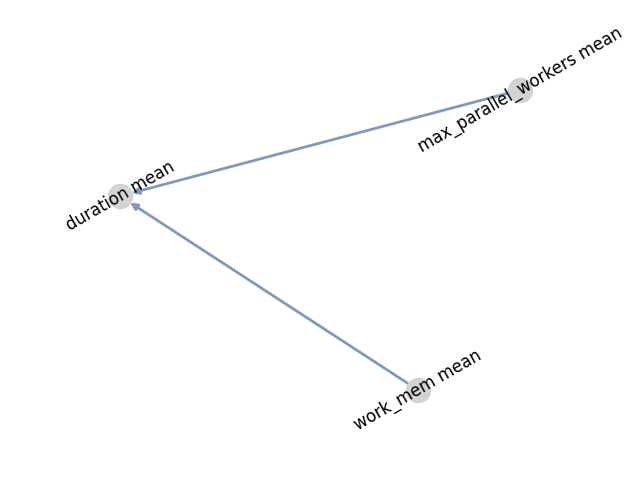

(0.9731182795698925, '0f62d144_15+mean', '')

In [32]:
s2.accept('work_mem mean', 'duration mean', interactive=False)
s2.accept('max_parallel_workers mean', 'duration mean', interactive=False)
s2.reject_undecided_incoming('duration mean')

Let's now look at the corresponding ATE of the number of `max_parallel_workers` on the max query latency. Intuitively, more parallelism should help so this should be negative:

In [33]:
s2.get_adjusted_ate("max_parallel_workers mean", "duration mean")

What if we hadn't considered the amount of working memory as a cause?

In [34]:
s2.get_unadjusted_ate("max_parallel_workers mean", "duration mean")

Surprising discrepancy! Let's look at the underlying data though:

In [35]:
t = s2.prepared_log[["0f62d144_15+mean", "d046ac78_14+mean", "2dfe3d16_11+mean"]]
t.columns = ["work_mem", "max_parallel_workers", "mean_latency"]
t

,work_mem,max_parallel_workers,mean_latency
sessionID+first,,,
6542c92d.1f943,128.0,1.0,13483.595990
6542d880.1fc1b,128.0,1.0,13126.180309
6542e76c.1fe63,64.0,2.0,22983.408399
6543018c.20227,64.0,2.0,23075.070997
65431bc7.20615,256.0,1.0,2707.956093
65431ef0.2073a,256.0,1.0,2781.880526
6543221a.2085f,128.0,2.0,13000.099663
654330e1.20b8f,128.0,2.0,13005.023144


Indeed, for a fixed amount of working memory, more parallelism leads to lower latency. But because of how we set up the experiment, more parallelism comes at the expense of working memory, so naively looking at only the 2 right-hand columns above would indeed make us think that more parallelism means *higher* latency!